In [1]:
import sys
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:37:41) 
[Clang 10.0.1 ]


In [2]:
# import libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cleaning

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [77]:

query = "SELECT date, temp_avg, dp_avg, humid_avg, ws_avg, precip FROM daily WHERE date > '2014-01-01' ORDER BY date"
wdf = cleaning.get_df_from_sql(query)
cleaning.set_precip_level(wdf, 0)
wdf.raining.value_counts()
#wdf['temp_kelvin'] = cleaning.convert_to_kelvin(wdf.temp_avg)

0    1641
1     823
Name: raining, dtype: int64

In [86]:
1642+823

2465

In [13]:
wdf.columns

Index(['date', 'temp_max', 'temp_avg', 'temp_min', 'dp_max', 'dp_avg',
       'dp_min', 'humid_max', 'humid_avg', 'humid_min', 'ws_max', 'ws_avg',
       'ws_min', 'press_max', 'press_avg', 'press_min', 'precip'],
      dtype='object')

In [12]:
len(wdf)

11200

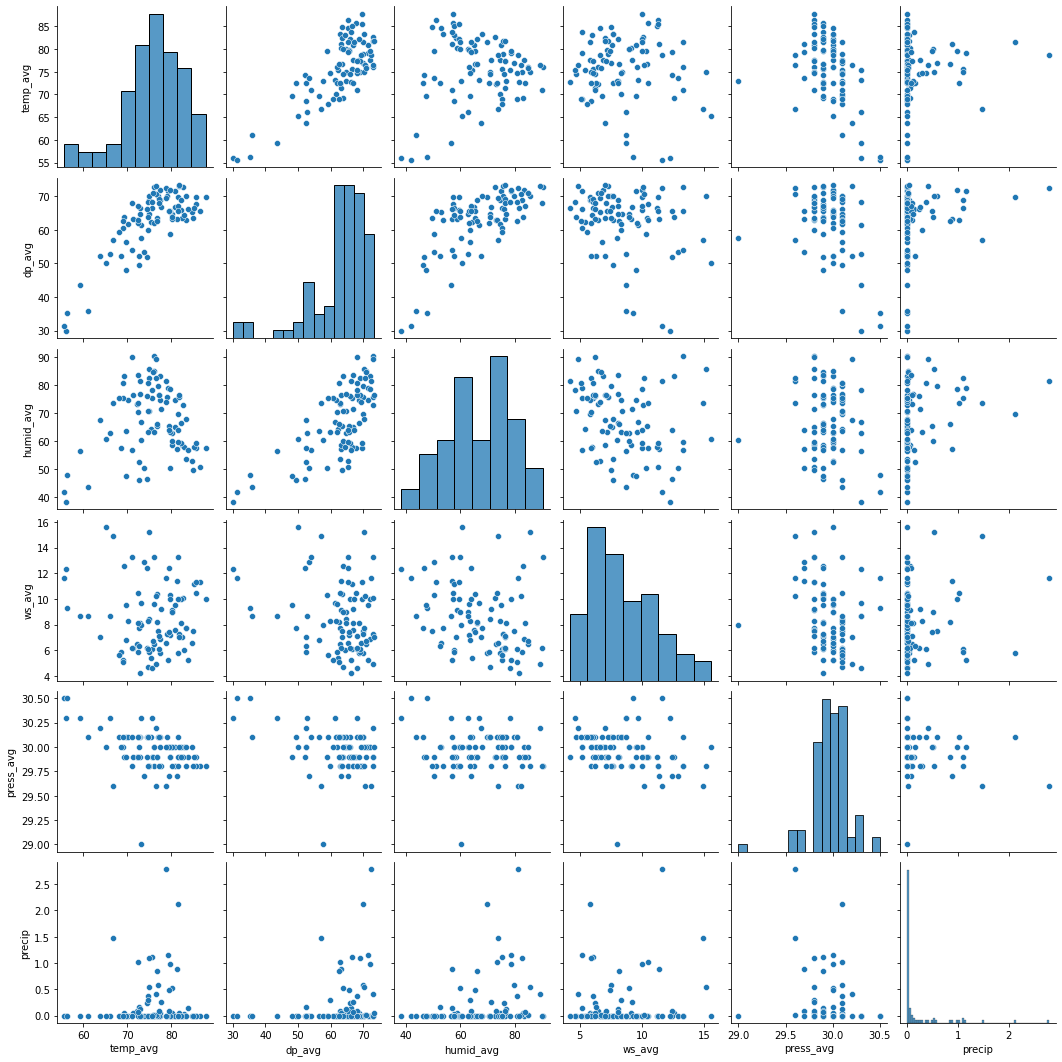

In [6]:
sns.pairplot(wdf);
# Takaways from Pairplot:
# Higher Pressure small correlation with precip
# dp and humidity + dp and temp are correlated
# humidity and ws look normal

In [19]:
wdf.head()

,date,temp_avg,dp_avg,humid_avg,ws_avg,press_avg,precip,temp_kelvin
0,2020-01-02,39.0,25.7,60.6,7.6,29.9,0.00,277.038889
1,2020-01-03,46.0,42.1,86.5,6.0,29.8,0.01,280.927778
2,2020-01-04,48.1,46.2,93.6,4.8,29.6,0.00,282.094444
3,2020-01-05,39.1,21.3,49.4,16.3,29.8,0.01,277.094444
4,2020-01-06,36.3,27.7,73.4,9.2,29.9,0.03,275.538889


<AxesSubplot:xlabel='date', ylabel='humid_avg'>

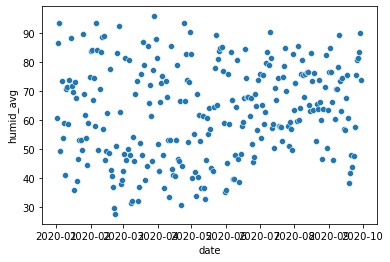

In [67]:
sns.scatterplot(x='date', y='humid_avg', data=wdf)

In [26]:
# Check for stationality 
hdf = wdf[['date', 'humid_avg']]
hdf.set_index('date', inplace=True)

7.0

In [10]:
roll_mean = hdf.rolling(window=10).mean()
roll_std = hdf.rolling(window=10).std()

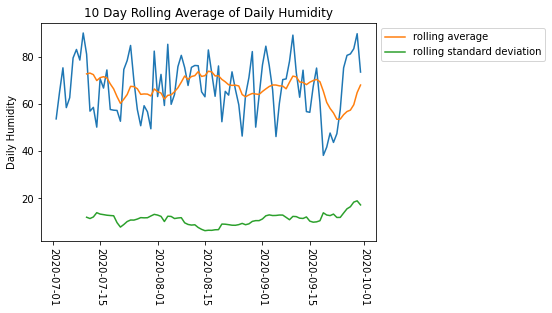

In [11]:
plt.plot(hdf)
plt.plot(roll_mean, label='rolling average')
plt.plot(roll_std, label='rolling standard deviation')
plt.ylabel('Daily Humidity')
plt.xticks(rotation=270)
plt.title('10 Day Rolling Average of Daily Humidity')
plt.legend(bbox_to_anchor=(1,1));

In [12]:
log_hdf = np.log(hdf)
log_roll_mean = log_hdf.rolling(window=5).mean()
log_roll_std = log_hdf.rolling(window=5).std()

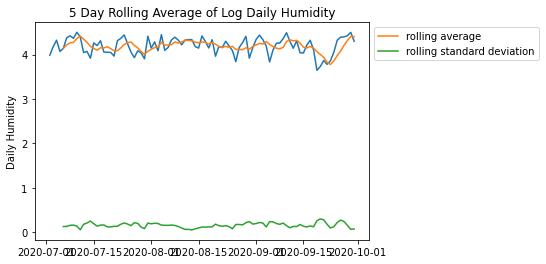

In [13]:
plt.plot(log_hdf)
plt.plot(log_roll_mean, label='rolling average')
plt.plot(log_roll_std, label='rolling standard deviation')
plt.ylabel('Daily Humidity')
plt.title('5 Day Rolling Average of Log Daily Humidity')
plt.legend(bbox_to_anchor=(1,1));

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(log_hdf)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.725853
p-value: 0.000001
	1%: -3.505
	5%: -2.894
	10%: -2.584


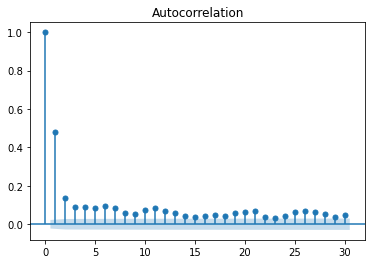

In [72]:
plot_acf(wdf.humid_avg, lags=30);

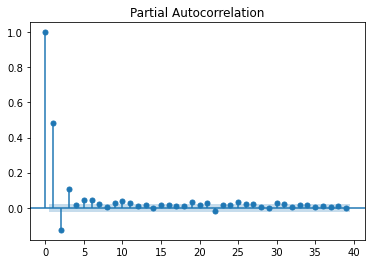

In [70]:
plot_pacf(wdf.humid_avg);

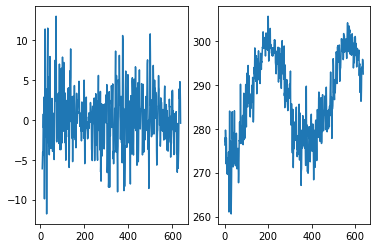

In [94]:
query = "SELECT date, temp_avg, dp_avg, humid_avg, ws_avg, precip FROM daily WHERE date > '2019-01-01' ORDER BY date"
wdf = cleaning.get_df_from_sql(query)
wdf['temp_kelvin'] = cleaning.convert_to_kelvin(wdf.temp_avg)

_, ax = plt.subplots(ncols=2)
ax[1].plot(wdf.temp_kelvin)
ax[0].plot(wdf.temp_kelvin-wdf.temp_kelvin.rolling(window=10).mean())

In [96]:
wdf.temp_kelvin-wdf.temp_kelvin.rolling(window=10).mean()

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
633    2.927778
634    4.772222
635    4.200000
636    2.583333
637   -0.427778
Name: temp_kelvin, Length: 638, dtype: float64

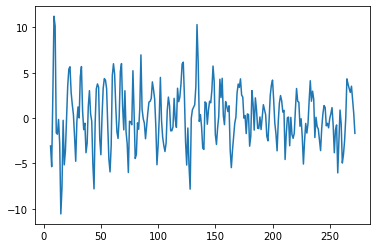

In [83]:
plt.plot(wdf.temp_kelvin-wdf.temp_kelvin.rolling(window=7).mean())

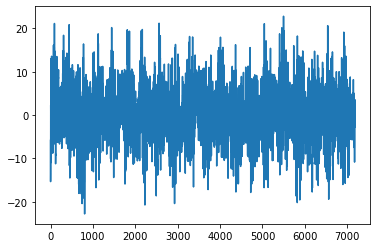

In [40]:
# Address seasonality with temperature
def create_difference(dataset, lag=1):
    d = [(dataset[i] - dataset[i-lag]) for i in range(lag, len(dataset))]
    return d

plt.plot(create_difference(wdf.temp_kelvin, 365))

In [97]:
wdf.temp_kelvin-wdf.temp_kelvin.rolling(window=7).mean()

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
633    2.825397
634    3.515873
635    2.063492
636    0.484127
637   -1.682540
Name: temp_kelvin, Length: 638, dtype: float64

In [99]:
wdf.date.map(lambda x: x.month)

0      1
1      1
2      1
3      1
4      1
      ..
633    9
634    9
635    9
636    9
637    9
Name: date, Length: 638, dtype: int64

In [14]:
wdf = pd.read_pickle('/Users/andrew/Metis-Project-3/src/EWRweather_cleaned.pickle')

In [82]:
# newtemp = Yesterday's rolling(10) average + C1 * (Lag1 error) + C2*(lag2 error)

hdf = wdf[['date', 'humid_avg']]

In [83]:

# create rolling average
roll_col = 'humid_avg' + '_roll_' + str(10)
hdf[roll_col] = hdf.humid_avg.rolling(window=10).mean()
col_err = 'humid_avg' + '_error'
hdf[col_err] = hdf['humid_avg'] - hdf[roll_col]
# get diff

# lag columns 
lags = range(1,3)
columns_to_lag = [col_err]
hdf = hdf.assign(**{col_err+'_lag_'+str(lag_n): hdf[col_err].shift(lag_n) for lag_n in lags}) 

In [98]:
# Build model to find smallest C1 and C2
# target = humid avg
# target = humid_avg + C1(E1) + C2(E2)
y = hdf.humid_avg[12:] # needs to start one after the last lag and cut off the last day 
X = hdf[['humid_avg_roll_10', 'humid_avg_error_lag_1', 'humid_avg_error_lag_2']][:-1]
X.dropna(inplace=True)
assert len(X) == len(y)

,humid_avg_roll_10,humid_avg_error_lag_1,humid_avg_error_lag_2
11,66.66,-5.09,27.36
12,69.99,1.04,-5.09
13,70.55,17.91,1.04
14,69.95,23.85,17.91
15,72.33,4.45,23.85
...,...,...,...
2458,55.60,3.99,-6.13
2459,56.93,19.90,3.99
2460,57.53,23.87,19.90
2461,59.82,23.87,23.87


In [97]:
len(y)

2452